# Experimental speckle phase retrieval

### Imports and data loading

Load the libraries

In [5]:
%load_ext autoreload
%autoreload 2

import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb
from scipy.io import loadmat
import numpy as np

import speckleret as spr
import speckleret.torch as tspr

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Load the interferometric data

In [6]:
def load_image_from_txt(filepath: str, width: int = 1936, height: int = 1216, header_lines: int = 21) -> np.ndarray:
    """
    Load pixel data from a text file into a NumPy array.

    Args:
        filepath (str): Path to the .txt file.
        width (int): Image width in pixels.
        height (int): Image height in pixels.
        header_lines (int): Number of header lines to skip.

    Returns:
        np.ndarray: 2D array of shape (height, width) containing the image data.
    """
    with open(filepath, "r") as f:
        lines = f.readlines()

    # Skip header lines
    pixel_lines = lines[header_lines:]

    # Join all lines and convert to integer array
    pixel_str = " ".join(pixel_lines)
    pixels = np.fromstring(pixel_str, sep=' ', dtype=int)

    # Reshape to image
    height = pixels.size / width
    return pixels.reshape((int(height), int(width)))

path = r'C:\Users\saucourt\Downloads\3_7_2025_DATA'
date = '380'

img_width = 512
half_img_width = img_width // 2
nf_central_row = 700
nf_central_col = 1070
ff_central_row = 565
ff_central_col = 860


CP = load_image_from_txt(os.path.join(path, date + 'N.txt'))[(nf_central_row-half_img_width):(nf_central_row+half_img_width), (nf_central_col-half_img_width):(nf_central_col+half_img_width)]
CL = load_image_from_txt(os.path.join(path, date + 'F.txt'))[(ff_central_row-half_img_width):(ff_central_row+half_img_width), (ff_central_col-half_img_width):(ff_central_col+half_img_width)]


CP = np.expand_dims(CP, axis=0)
CL = np.expand_dims(CL, axis=0)
print(CP.shape)
print(CL.shape)

(1, 512, 512)
(1, 512, 512)


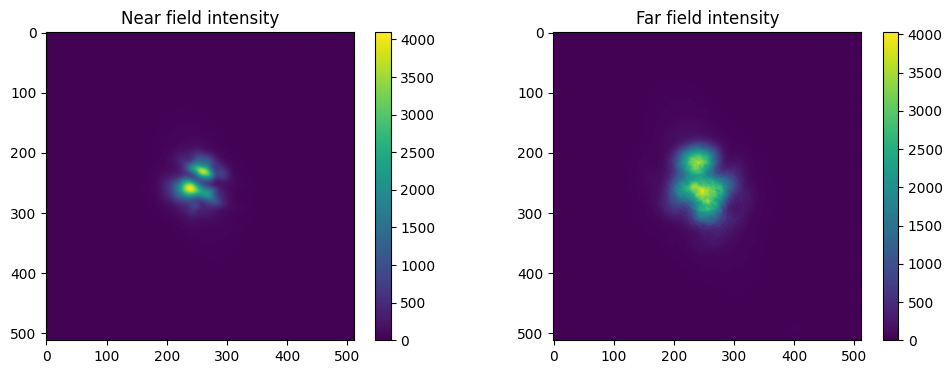

In [7]:
idx = 0

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.imshow(CP[idx, ...], vmin=0)
plt.title('Near field intensity')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(CL[idx, ...], vmin=0)
plt.title('Far field intensity')
plt.colorbar()

### Data cleanup: noise removal and centroid detection

Let's remove the noise from the measured far field

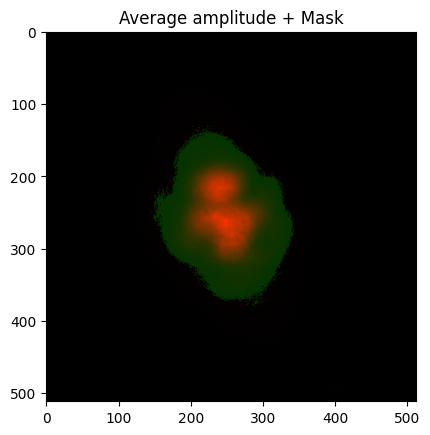

21.15009307861328


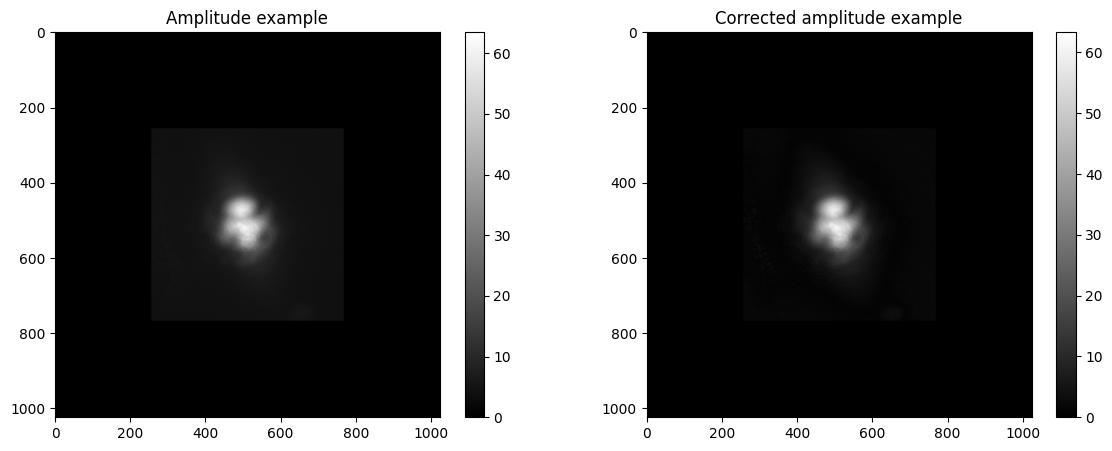

In [8]:
noise_corr = spr.utils.extract_noise_correction(CL, averaging_axis=(0,), mask_trsh=0.02, plot_result=True, plot_mask=True)
print(noise_corr)

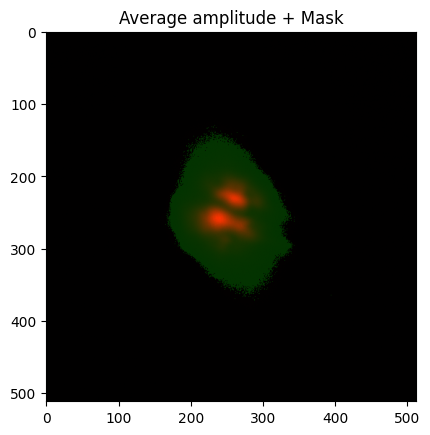

17.98654556274414


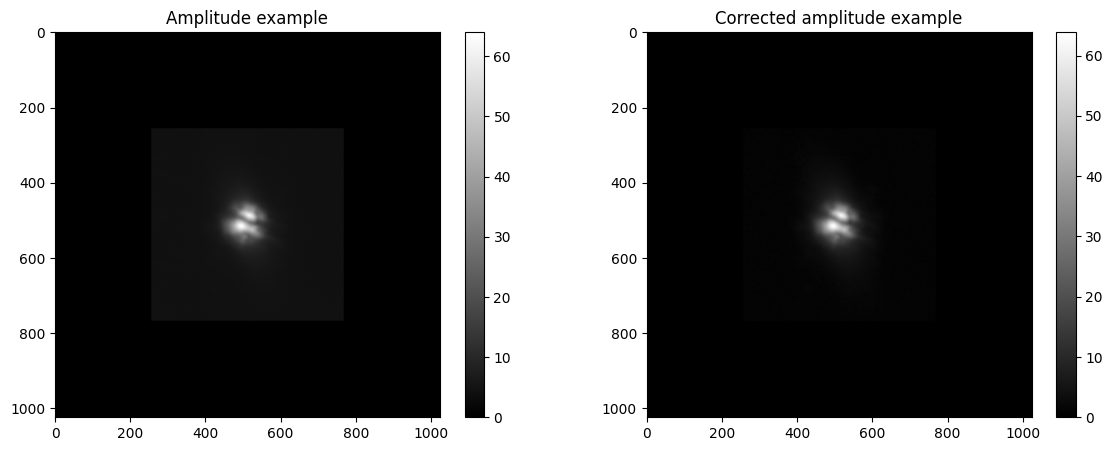

In [9]:
noise_corrCP = spr.utils.extract_noise_correction(CP, averaging_axis=(0,), mask_trsh=0.01, plot_mask=True, plot_result=True)
print(noise_corrCP)

Let's detect the average centroids

In [10]:
centroids_CP = spr.utils.extract_average_centroid(CP, averaging_axis=(-1, -2))
centroids_CL = spr.utils.extract_average_centroid(CL, averaging_axis=(-1, -2))

print(f"Average centroid CP: {centroids_CP}")
print(f"Average centroid CL: {centroids_CL}")

Average centroid CP: (0.0, 255.49792356548537)
Average centroid CL: (0.0, 256.4750342816004)


### Data preparation

Select data for phase retrieval

193
(192, 192) 706504.3996434631
(192, 192) 1595417.3359447522


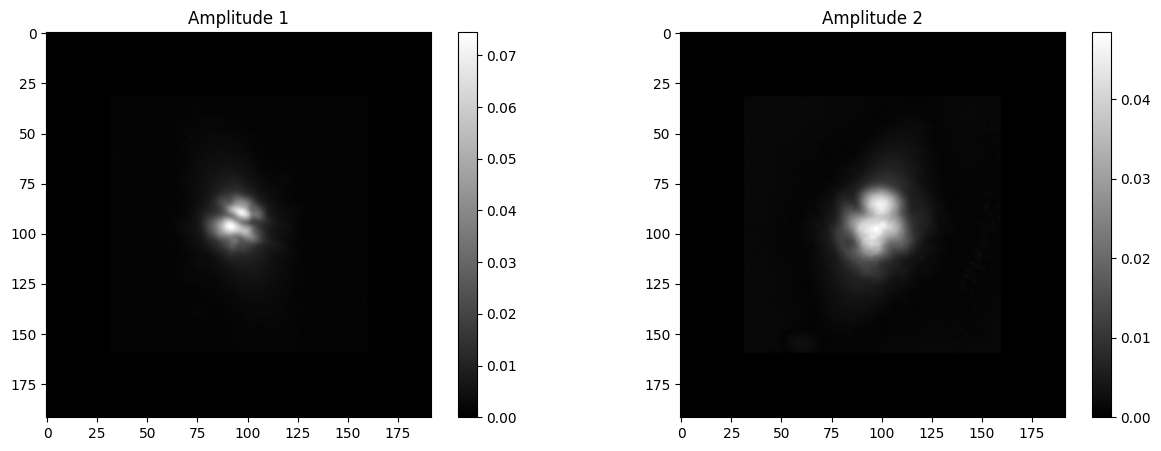

In [144]:
idx = 0
random: bool = False
if random:
    idx = np.random.randint(0, len(CP))


def compute_N_win(wavelength, focal_length, pixel_size1, pixel_size2):
    return int(wavelength * focal_length / (pixel_size1 * pixel_size2))


pixel_cp = 5.86e-6
pixel_cl = 5.86e-6
bin_cp = 4
bin_cl = 4
wavelength = 1064e-9
focal_length = 100e-3
N_window = compute_N_win(wavelength, focal_length, bin_cp * pixel_cp, bin_cl * pixel_cl)
print(N_window)


field = np.sqrt(np.abs(CP[idx, ...] - noise_corrCP)) #

# CP_shift = (np.array(centroids_CP) - np.array(field.shape) / 2).astype(int)
field = spr.utils.bin_image(field, factor=bin_cp)
f_shape = field.shape
f_pad = (N_window - f_shape[0]) // 2
field = np.pad(field, [f_pad, f_pad])

field_energy = np.sum(np.square(np.abs(field)))
field = field / np.sqrt(field_energy)
print(field.shape, field_energy)


ft = np.sqrt(np.abs(CL[idx, ...] - noise_corr)) #
# CL_shift = (np.array(centroids_CL) - np.array(ft.shape) / 2).astype(int) + np.array([-20, 10])
# ft = np.roll(ft, shift=-CL_shift, axis=(0,1))
ft = spr.utils.bin_image(ft, factor=bin_cl)
ft_shape = ft.shape
ft_pad = (N_window - ft_shape[0]) // 2
ft = np.pad(ft, [ft_pad, ft_pad])
# ft = np.flip(ft, axis=0)
ft = np.flip(ft, axis=1)

ft_energy = np.sum(np.square(np.abs(ft)))
ft = ft / np.sqrt(ft_energy)
print(ft.shape, ft_energy)

_ = spr.plots.compare_arrays(field, ft, cmap='gray')

Check that the Fourier transform of the field matches with the measured (perhaps resampled) one. Any shift will lead to a phase slope in the retrieved phase

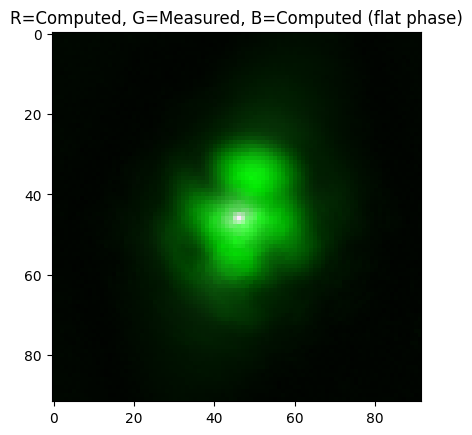

In [145]:
ft_field_flat = spr.transforms.fourier_transform(np.abs(field))
ft_field = spr.transforms.fourier_transform(field)
win_crop = 50

R = np.abs(ft_field[win_crop:-win_crop, win_crop:-win_crop])
G = np.abs(ft[win_crop:-win_crop, win_crop:-win_crop])
B = np.abs(ft_field_flat[win_crop:-win_crop, win_crop:-win_crop])

R /= np.max(R)
G /= np.max(G)
B /= np.max(B)

_ = spr.plots.rgb_imshow([R, G, B])
_ = plt.title("R=Computed, G=Measured, B=Computed (flat phase)")

Define the phase retrieval support

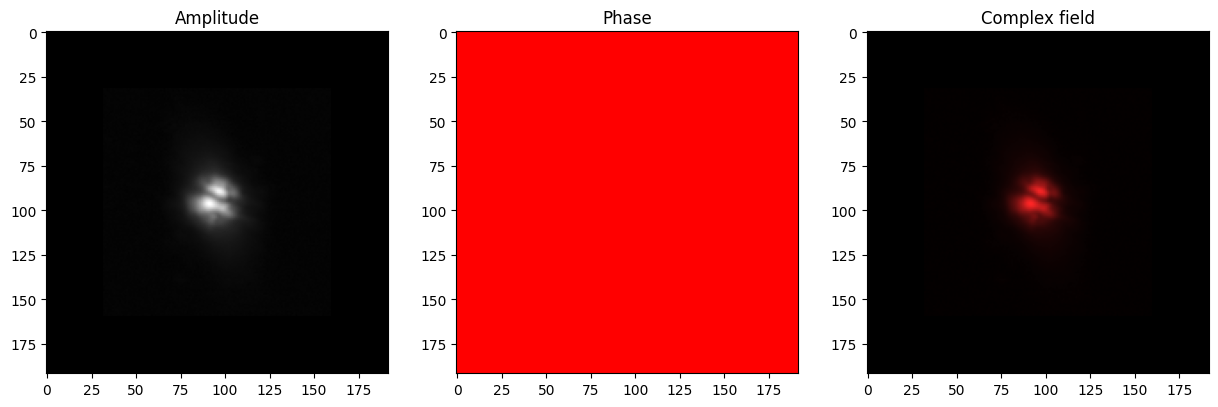

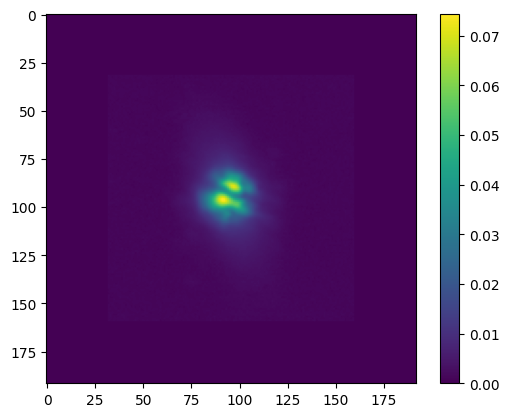

In [146]:
support = spr.supports.threshold_support(field, threshold=0.00)
# support = spr.supports.disk_support(field, radius=90, offsets=(0,0))
supported_field = field.copy()
supported_field[np.logical_not(support)] = np.nan
_ = spr.plots.complex_imshow(supported_field)

plt.figure()
plt.imshow(supported_field)
plt.colorbar()

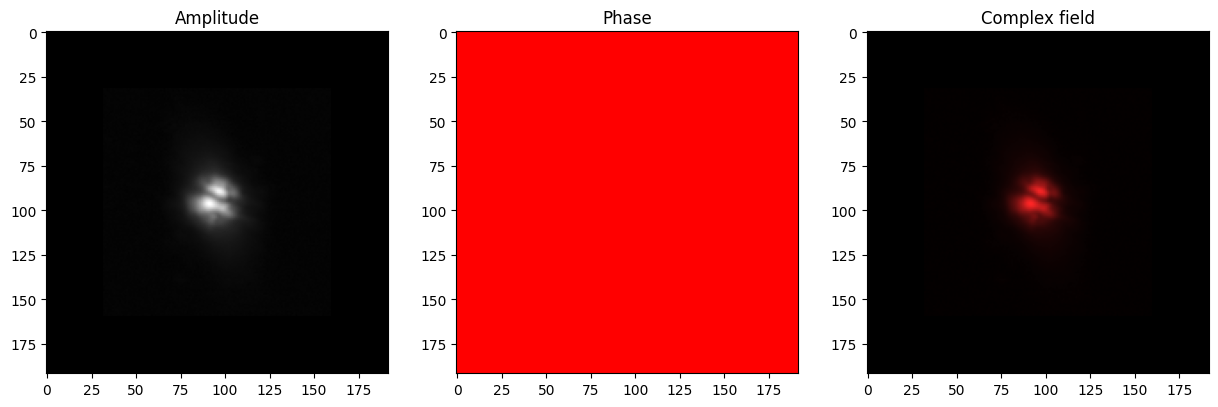

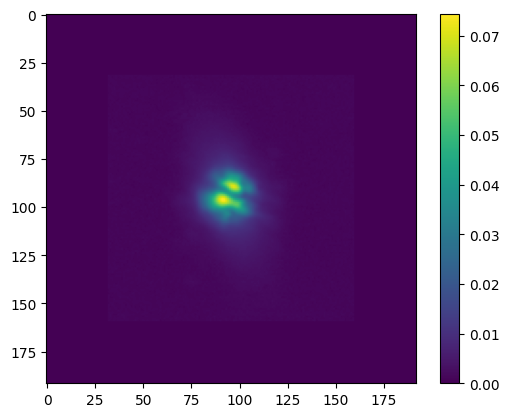

In [147]:
import torch

tfield = torch.from_numpy(field).to(torch.float)
tfield = tfield.unsqueeze(0).unsqueeze(0)

support = tspr.supports.threshold_support(tfield, threshold=0.00)
# support = spr.supports.disk_support(tfield, radius=90, offsets=(0,0))
supported_field = tspr.transforms.apply_support(tfield, support)
_ = spr.plots.complex_imshow(supported_field.cpu().detach().numpy().squeeze())

plt.figure()
plt.imshow(supported_field.cpu().detach().numpy().squeeze())
plt.colorbar()

In [131]:
support.shape

torch.Size([1, 1, 192, 192])

### Testing other phase retrieval algorithms !?!

There are plenty of them based on iterative projections/reflections. It seems that RAAR or OSS works well.

In [148]:
from matplotlib.colors import hsv_to_rgb

def merge_dicts(dict_list) -> dict:
    merged_dict = {}
    for d in dict_list:
        for key, array in d.items():
            if key in merged_dict:
                merged_dict[key] = torch.concatenate((merged_dict[key], array))
            else:
                merged_dict[key] = array  # Initialize with first occurrence
    return merged_dict

Iteration 0, Loss: 0.9439250826835632
Iteration 10, Loss: 0.07310527563095093
Iteration 20, Loss: 0.031219542026519775
Iteration 30, Loss: 0.015886008739471436
Iteration 40, Loss: 0.009288012981414795


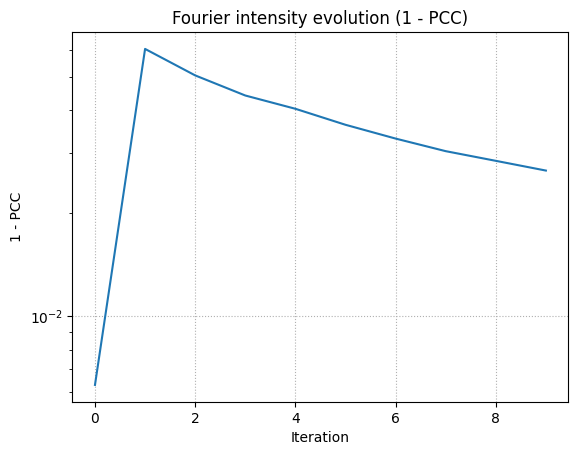

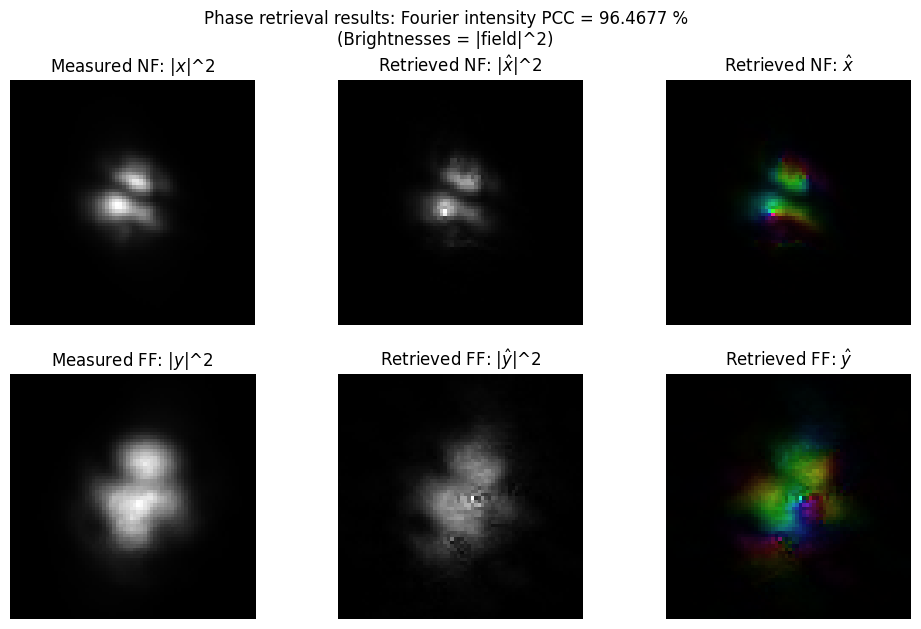

In [270]:
import torch.optim as optim

tft = torch.from_numpy(ft).to(torch.float)
tft = tft.unsqueeze(0).unsqueeze(0)


device = 'cuda'

tfield = tfield.to(device)
tft = tft.to(device)
support = support.to(device)




results = []

x, result = tspr.retrieval.run(
        magnitudes=(torch.abs(tfield), torch.abs(tft)),
        support=support,
        # init=x,
        init=tspr.initializers.gradient_descent(
                magnitude_near_field=torch.abs(tfield),
                magnitude_far_field=torch.abs(tft),
                support=support,
                optimizer_class=torch.optim.Adam,
                optimizer_kwargs=dict(lr=1e-0),
                max_iter=50,
        ),
        # init=tspr.initializers.flat_phases(torch.abs(tfield)),
        # init=tspr.initializers.random_phases(torch.abs(tfield)),
        algorithm=tspr.retrieval.SF,
        # algorithm_kwargs={'beta': 0.99},
        max_iter=10,
)
results.append(result)


# x, result = tspr.retrieval.run(
#         magnitudes=(torch.abs(tfield), torch.abs(tft)),
#         support=support,
#         init=x,
#         # init=spr.initializers.flat_phases(magnitude=np.abs(field)),
#         # init=tspr.initializers.random_phases(np.abs(tfield)),
#         algorithm=tspr.retrieval.ER,
#         # algorithm_kwargs={'beta': 0.99},
#         max_iter=200,
# )
# results.append(result)



tspr.retrieval.report_convergence_results(merge_dicts(results), key='pearson_fourier')

x_hat = x
y_hat = tspr.transforms.fourier_transform(x_hat)




hfig = spr.retrievalmath.show_retrieved_fields(
    tfield.cpu().detach().squeeze().numpy(), 
    tft.cpu().detach().squeeze().numpy(),
    x_hat.cpu().detach().squeeze().numpy(),
    y_hat.cpu().detach().squeeze().numpy(),
    power=2,
    window_crop=60,
)

In [268]:
x_hat

(tensor([[[[0.+0.j, 0.+0.j, 0.-0.j,  ..., 0.+0.j, 0.+0.j, 0.+0.j],
           [0.+0.j, 0.+0.j, 0.+0.j,  ..., 0.+0.j, 0.+0.j, 0.+0.j],
           [0.+0.j, 0.+0.j, 0.+0.j,  ..., 0.+0.j, 0.+0.j, 0.+0.j],
           ...,
           [0.+0.j, 0.+0.j, 0.+0.j,  ..., 0.+0.j, 0.+0.j, 0.+0.j],
           [0.+0.j, 0.+0.j, 0.+0.j,  ..., 0.+0.j, 0.+0.j, 0.+0.j],
           [0.+0.j, 0.+0.j, 0.+0.j,  ..., 0.+0.j, 0.+0.j, 0.+0.j]]]],
        device='cuda:0'),)

Iteration 0, Loss: 0.40487438440322876
Iteration 10, Loss: 0.154252827167511
Iteration 20, Loss: 0.06549321860074997
Iteration 30, Loss: 0.03377443552017212
Iteration 40, Loss: 0.022961409762501717
Iteration 50, Loss: 0.01739131286740303
Iteration 60, Loss: 0.014816610142588615
Iteration 70, Loss: 0.013447214849293232
Iteration 80, Loss: 0.012669730931520462
Iteration 90, Loss: 0.012145871296525002


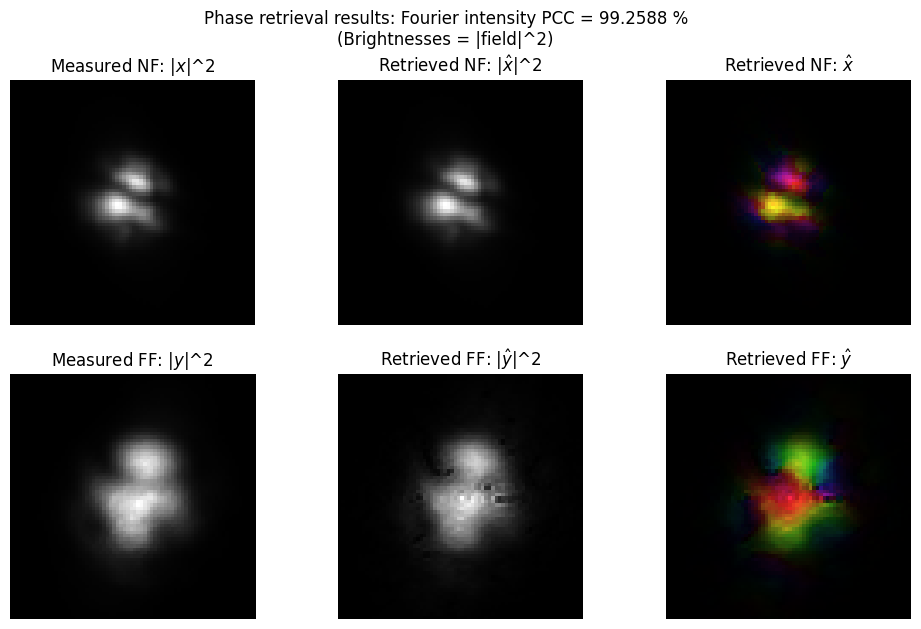

In [261]:
import torch.nn as nn
import torch.optim as optim

def total_variation_loss(x: torch.Tensor) -> torch.Tensor:
    diff_x = x[..., :, 1:] - x[..., :, :-1]   # shape [N,C,H,W-1]
    diff_y = x[..., 1:, :] - x[..., :-1, :]   # shape [N,C,H-1,W]

    # Compute L1 norm of gradients separately, then sum
    tv_x = diff_x.abs().mean()
    tv_y = diff_y.abs().mean()

    return tv_x + tv_y

class PhaseOnlyOptimizer(nn.Module):
    def __init__(
        self,
        init_magnitude: torch.Tensor,   # [N,C,H,W], fixed magnitude
        init_phase: torch.Tensor,       # [N,C,H,W], initial phase guess
        support: torch.Tensor = None    # [N,C,H,W], optional support mask
    ):
        super().__init__()
        self.register_buffer('magnitude', init_magnitude)
        self.register_buffer('support', support if support is not None else torch.ones_like(init_magnitude, dtype=torch.bool))

        # Learnable phase parameter, initialized with init_phase
        self.phase = nn.Parameter(init_phase.clone())

    def forward(self):
        # Compose complex field: fixed magnitude * learned phase
        x = self.magnitude * torch.exp(1j * self.phase)
        # Apply support mask if provided
        x = torch.where(self.support, x, torch.tensor(0.0, dtype=x.dtype, device=x.device))
        return x

    def loss(self, target_fourier_magnitude: torch.Tensor, tv_weight=1e-3):
        x = self.forward()
        x_fft = tspr.transforms.fourier_transform(x)
        x_fft_mag = torch.abs(x_fft)

        pearson_loss = torch.mean(tspr.metrics.pearson(x_fft_mag, target_fourier_magnitude, inversed=True))
        tv_loss = total_variation_loss(self.phase)

        return pearson_loss + tv_weight * tv_loss
    

# model = PhaseOnlyOptimizer(torch.abs(x_hat), init_phase=torch.angle(x_hat), support=support)
model = PhaseOnlyOptimizer(torch.abs(x_hat), init_phase=torch.zeros_like(torch.angle(x_hat)), support=support)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-1)

for i in range(100):
    optimizer.zero_grad()
    loss = model.loss(torch.abs(tft), tv_weight=1e-2)
    loss.backward()
    optimizer.step()

    if i % 10 == 0:
        print(f"Iteration {i}, Loss: {loss.item()}")

x_out = torch.abs(x_hat) * torch.exp(1j * model.phase)
y_out = tspr.transforms.fourier_transform(x_out)



hfig = spr.retrievalmath.show_retrieved_fields(
    tfield.cpu().detach().squeeze().numpy(), 
    tft.cpu().detach().squeeze().numpy(),
    x_out.cpu().detach().squeeze().numpy(),
    y_out.cpu().detach().squeeze().numpy(),
    power=2,
    window_crop=60,
)

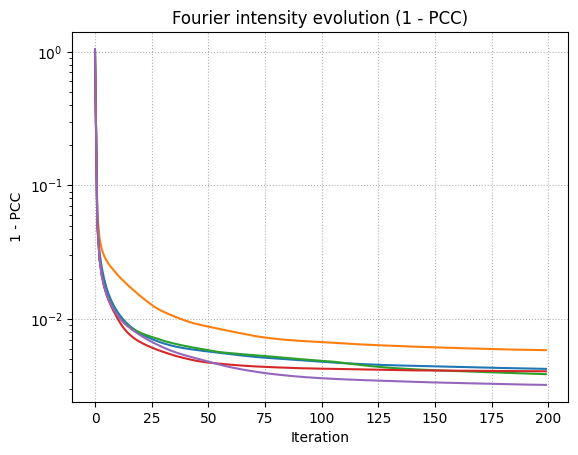

In [209]:
tft = torch.from_numpy(ft).to(torch.float)
tft = tft.unsqueeze(0).unsqueeze(0)

N=5

device = 'cuda'

tfield = tfield.to(device)
tft = tft.to(device)
support = support.to(device)

nsupport = support.repeat(N, 1, 1, 1)
ntft = tft.repeat(N, 1, 1, 1)
ntfield = tfield.repeat(N, 1, 1, 1)


results = []

x, result = tspr.retrieval.run(
        magnitudes=(torch.abs(ntfield), torch.abs(ntft)),
        support=nsupport,
        # init=x,
        # init=tspr.initializers.flat_phases(torch.abs(ntfield)),
        init=tspr.initializers.random_phases(torch.abs(ntfield)),
        algorithm=tspr.retrieval.ER,
        # algorithm_kwargs={'beta': 0.99},
        max_iter=200,
)
results.append(result)


# x, result = tspr.retrieval.run(
#         magnitudes=(torch.abs(ntfield), torch.abs(ntft)),
#         support=nsupport,
#         init=x,
#         # init=spr.initializers.flat_phases(magnitude=np.abs(field)),
#         # init=tspr.initializers.random_phases(np.abs(tfield)),
#         algorithm=tspr.retrieval.ER,
#         # algorithm_kwargs={'beta': 0.99},
#         max_iter=200,
# )
# results.append(result)



tspr.retrieval.report_convergence_results(merge_dicts(results), key='pearson_fourier')

x_hat = x
y_hat = tspr.transforms.fourier_transform(x_hat)

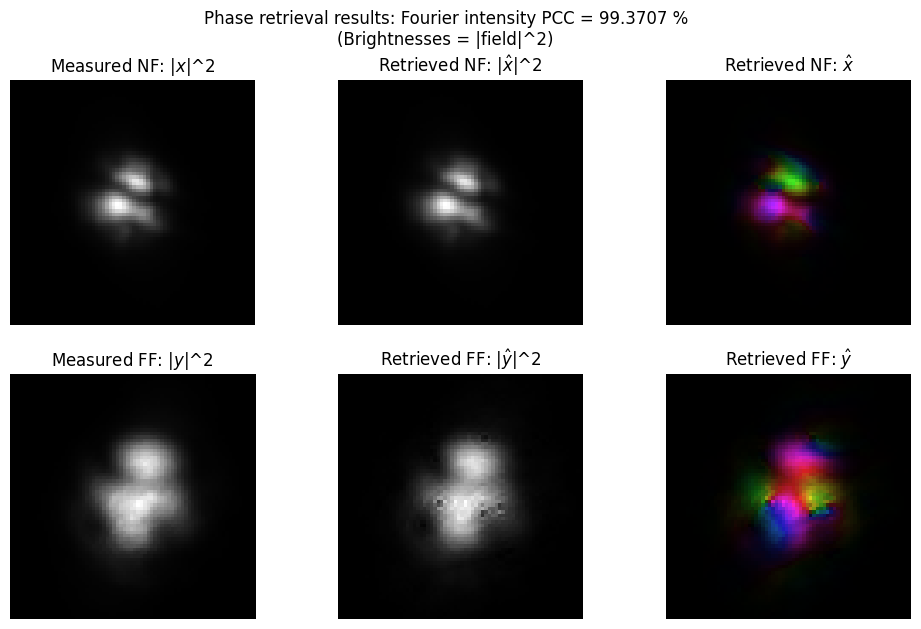

In [210]:
idx = 0

hfig = spr.retrievalmath.show_retrieved_fields(
    ntfield[idx, ...].cpu().detach().squeeze().numpy(), 
    ntft[idx, ...].cpu().detach().squeeze().numpy(),
    x_hat[idx, ...].cpu().detach().squeeze().numpy(),
    y_hat[idx, ...].cpu().detach().squeeze().numpy(),
    power=2,
    window_crop=60,
)

In [488]:
from scipy.io import savemat

savemat(
    file_name=os.path.join(path, 'phase_retrieval_data_' + date + '.mat'),
    mdict=dict(
        field=field,
        fourier=ft,
        retrieved_field=x_hat,
        retrieved_fourier=y_hat,
        pr_results=results,
        wavelength=wavelength,
        focal_length=focal_length,
        bin_cp = bin_cp,
        bin_cl = bin_cl,
        pixel_cp = pixel_cp,
        pixel_cl = pixel_cl,
    )
)

hfig.savefig( os.path.join(path, 'phase_retrieval_plot_' + date + '.png'))